<a href="https://colab.research.google.com/github/jaganbatna/App-Recommendation-Using-KNN/blob/main/Playstore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors

In [3]:
# Load dataset
df = pd.read_csv("googleplaystore.csv")

In [4]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [5]:
df.drop_duplicates(subset='App', inplace=True)

# **1. Exploratory Data Analysis (EDA)**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9660 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9660 non-null   object 
 1   Category        9660 non-null   object 
 2   Rating          8197 non-null   float64
 3   Reviews         9660 non-null   object 
 4   Size            9660 non-null   object 
 5   Installs        9660 non-null   object 
 6   Type            9659 non-null   object 
 7   Price           9660 non-null   object 
 8   Content Rating  9659 non-null   object 
 9   Genres          9660 non-null   object 
 10  Last Updated    9660 non-null   object 
 11  Current Ver     9652 non-null   object 
 12  Android Ver     9657 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1.0+ MB


In [7]:
df.isnull().sum()

,0
App,0
Category,0
Rating,1463
Reviews,0
Size,0
Installs,0
Type,1
Price,0
Content Rating,1
Genres,0


In [8]:

print("\n--- Category Distribution ---")
print(df['Category'].value_counts().head())


--- Category Distribution ---
Category
FAMILY      1832
GAME         959
TOOLS        827
BUSINESS     420
MEDICAL      395
Name: count, dtype: int64


# **Visualizations**

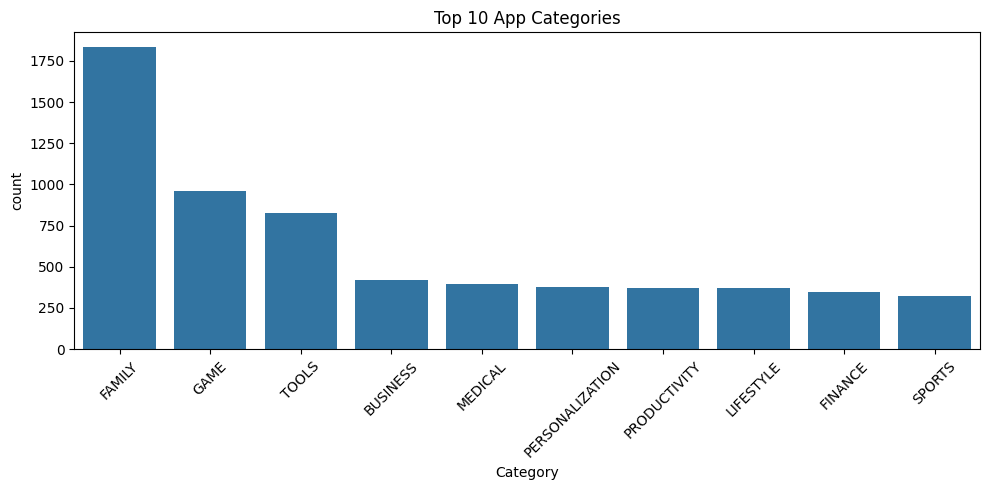

In [9]:

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index[:10])
plt.xticks(rotation=45)
plt.title("Top 10 App Categories")
plt.tight_layout()
plt.show()

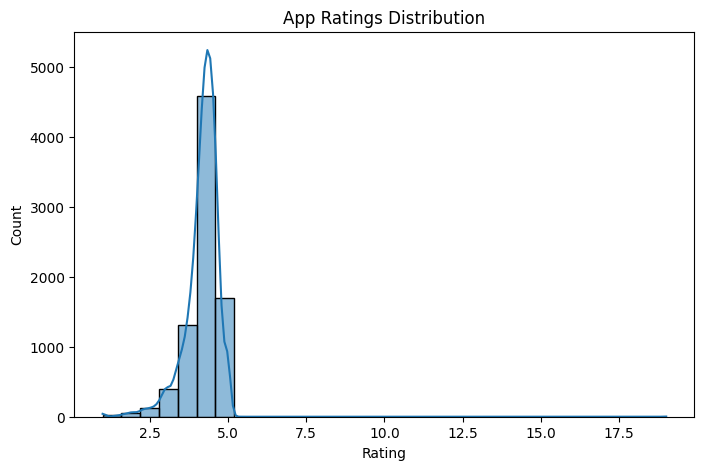

In [10]:

plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'].dropna(), bins=30, kde=True)
plt.title("App Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


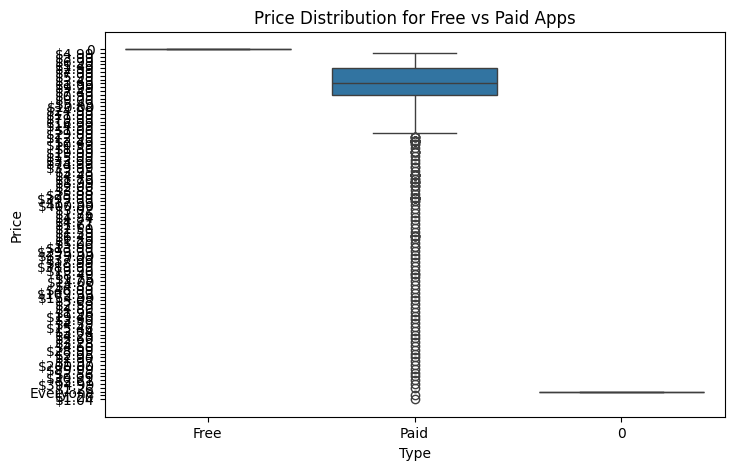

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Type', y='Price')
plt.title("Price Distribution for Free vs Paid Apps")
plt.show()

# 2. Data Cleaning

In [12]:
# Reviews
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

In [13]:
# Price
df['Price'] = df['Price'].str.replace('$', '', regex=True).str.replace(',', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

In [14]:
# Installs
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

In [15]:

# Size
def size_to_mb(size):
    if 'M' in size:
        return float(size.replace('M',''))
    elif 'k' in size:
        return float(size.replace('k','')) / 1024
    else:
        return np.nan

In [16]:
df['Size'] = df['Size'].replace('Varies with device', np.nan)
df['Size'] = df['Size'].apply(lambda x: size_to_mb(str(x)))

In [17]:
# Fill missing values
imputer = SimpleImputer(strategy='median')
df[['Rating', 'Reviews', 'Size', 'Installs', 'Price']] = imputer.fit_transform(df[['Rating', 'Reviews', 'Size', 'Installs', 'Price']])

# 3. Feature Engineering

In [18]:
label_encoders = {}

for col in ['Category', 'Type', 'Content Rating']:
    le = LabelEncoder()
    df[col] = df[col].fillna('Unknown')
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [19]:
# Genres
df['Genres'] = df['Genres'].str.split(';').apply(lambda x: x[0])
le_genres = LabelEncoder()
df['Genres'] = le_genres.fit_transform(df['Genres'])

In [20]:
# Last Updated
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
latest_date = df['Last Updated'].max()
df['Days_Since_Update'] = (latest_date - df['Last Updated']).dt.days
df['Days_Since_Update'] = df['Days_Since_Update'].fillna(df['Days_Since_Update'].median())

In [21]:
# Final features
feature_cols = ['Category', 'Rating', 'Reviews', 'Size', 'Installs',
                'Type', 'Price', 'Content Rating', 'Genres', 'Days_Since_Update']
features = df[feature_cols]

In [22]:
# Scale features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 4. Build Recommendation System

In [23]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(features_scaled)

NearestNeighbors(algorithm='brute', metric='cosine')

# 5. Recommendation from Input

In [27]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(features_scaled)

def get_user_input():
    print("\nPlease enter your app preferences:\n")
    category = input("Enter Category (e.g., GAME, TOOLS): ").strip().upper()
    rating = float(input("Minimum Rating (e.g., 4.5): "))
    genre = input("Genre (e.g., Action, Education): ").strip().title()

    return category, rating, genre

def recommend_apps_from_input(n_recommendations=5):
    category, rating, genre = get_user_input()

    try:
        cat_encoded = label_encoders['Category'].transform([category])[0]
    except:
        print(f"Unknown category '{category}', using median.")
        cat_encoded = int(features['Category'].median())

    try:
        genre_encoded = le_genres.transform([genre])[0]
    except:
        print(f"Unknown genre '{genre}', using median.")
        genre_encoded = int(features['Genres'].median())

    # Create a user vector with all 10 features, using median for others
    user_vector = np.array([[
        cat_encoded,
        rating,
        features['Reviews'].median(), # Use median for Reviews
        features['Size'].median(),     # Use median for Size
        features['Installs'].median(), # Use median for Installs
        features['Type'].median(),     # Use median for Type
        features['Price'].median(),    # Use median for Price
        features['Content Rating'].median(), # Use median for Content Rating
        genre_encoded,
        features['Days_Since_Update'].median() # Use median for Days_Since_Update
    ]])

    user_scaled = scaler.transform(user_vector)

    distances, indices = model_knn.kneighbors(user_scaled, n_neighbors=n_recommendations)
    print("\n🎯 Based on your preferences, you might like these apps:")
    for idx in indices[0]:
        print(f"- {df.iloc[idx]['App']}")

# Run
recommend_apps_from_input()


Please enter your app preferences:

Enter Category (e.g., GAME, TOOLS): game
Minimum Rating (e.g., 4.5): 4
Genre (e.g., Action, Education): education

🎯 Based on your preferences, you might like these apps:
- EF Smart English
- BAC DZ Questionnaire
- Google Arts & Culture
- RightNow English Conversation
- Fr Agnel Pune


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
